# Figure 1 

[Jump](#Figure-generation) to the interesting stuff. 

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import networkx as nx
from latticeproteins.sequences import hamming_distance

## Functions

In [2]:
# ---------------------------------------------------------------------------
# Quantities calculated in this notebook
# ---------------------------------------------------------------------------

def calculate_theta(Gactual, Gpredicted, seq):
    """Take two networks and calculate total difference in flux between them.
    """
    Gdiff = modified_Gdiff(Gactual, Gpredicted)
    rings = ring_levels(Gdiff, seq)
    running_denom = 0
    running_diff = 0
    # Add to summary statistic
    for ring, sequences in rings.items():

        if  ring < 8:

            diff, denom1, denom2 = 0, 0, 0
            for i in sequences:

                # Add up total flux exchange, and the difference between two networks
                for j in Gdiff.neighbors(i):

                    diff += Gdiff.edge[i][j]["weight"]
                    try: denom1 += Gactual.edge[i][j]["delta_flux"]
                    except KeyError: pass

                    try: denom2 += Gpredicted.edge[i][j]["delta_flux"]
                    except KeyError: pass

            denom = denom1 + denom2
            #print(d, ring, denom, diff, seq)
            # Normalize the flux exchange at this hamming distance
            running_diff += diff
            running_denom += denom
    theta = running_diff / running_denom
    return theta

# ---------------------------------------------------------------------------
# Network construction functions
# ---------------------------------------------------------------------------

def flux_out_of_node(G, node_i):
    """Determine """
    # Get flux coming from source
    total_flux_avail = G.node[node_i]["flux"]
    
    edges = {}
    # Normalize the transition probability from source
    norm = sum([G.edge[node_i][node_j]["weight"] for node_j in G.neighbors(node_i)])
    #print(norm)
    # Iterate over neighbors divvy up flux across neighbors
    for node_j in G.neighbors(node_i):
        if norm > 0:
            fixation = G.edge[node_i][node_j]["weight"]
            dflux = (fixation/norm) * total_flux_avail
            G.edge[node_i][node_j]["delta_flux"] = dflux
            G.node[node_j]["flux"] += dflux
        else:
            G.edge[node_i][node_j]["delta_flux"] = 0
    return edges

def flux_from_source(G, source):
    # Reset the flux of each node
    init_flux = dict([(node, 0) for node in G.nodes()])
    nx.set_node_attributes(G, "flux", init_flux)
    G.node[source]["flux"] = 1
    # Add flux to each node.
    levels = ring_levels(G, source)
    for l in levels:
        for node_i in levels[l]:
            edges = flux_out_of_node(G, node_i)
            for key, flux_to_add in edges.items():
                node_i, node_j = key
                G.node[node_j]["flux"] += flux_to_add
    return G

def ring_levels(G, root):
    levels = dict([(i,[]) for i in range(20)])
    levels[0].append(root)
    for node in G.nodes():
        neighbors = G.neighbors(node)
        for neigh in neighbors:
            key = hamming_distance(root, neigh)
            levels[key].append(neigh)
    for key, val in levels.items():
        z = sorted(list(set(val)))
        levels[key] = z
    return levels

def build_graphs(edges0, edges1, edges2, source):
    """Construct two different networks from a set of edges.
    """
    # -----------------------------------------------
    # build initial graphs
    # -----------------------------------------------

    # Build Graph
    G0 = nx.DiGraph()
    for key, weight in edges0:
        i,j = key[0], key[1]
        G0.add_edge(i,j, weight=weight["weight"])
        
    G1 = nx.DiGraph()
    for key, weight in edges1:
        i,j = key[0], key[1]
        G1.add_edge(i,j, weight=weight["weight"])
        
    # Build Graph
    G2 = nx.DiGraph()
    for key, weight in edges2:
        i,j = key[0], key[1]
        G2.add_edge(i,j, weight=weight["weight"])

    seq = source
    
    # -----------------------------------------------
    # Calculate the flux at each node and edge
    # -----------------------------------------------
    
    G0 = flux_from_source(G0, seq)
    G1 = flux_from_source(G1, seq)
    G2 = flux_from_source(G2, seq)

    return G0, G1, G2


# ---------------------------------------------------------------------------
# Plotting functions
# ---------------------------------------------------------------------------

def radial(r, theta):
    return (r*np.cos(theta), r*np.sin(theta))

def ring_position(G, root):
    import random
    levels = ring_levels(G, root)
    pos = {}
    for i in range(len(levels)):
        nodes = levels[i]
        nodelist = list(nodes)
        random.shuffle(nodelist)
        rotate_translate = random.random()
        for j, node in enumerate(nodelist):
            angle = 2*np.pi / len(nodes)
            pos[node] = radial(i, j*angle + + rotate_translate)
    return pos


def modified_Gdiff(G0, G2):
    # Get a dictionary of change in fluxes along each edge.
    edges_0 = dict([((i, j), G0.edge[i][j]["delta_flux"]) for i,j in G0.edges()])
    edges_2 = dict([((i, j), G2.edge[i][j]["delta_flux"]) for i,j in G2.edges()])

    # -----------------------------------------------
    # Calculate the change in delta_flux on each edge
    # -----------------------------------------------
    edges_diff = {}
    # See what edges we lost
    for key, val in edges_0.items():
        if key in edges_2:
            weight = edges_2[key] - edges_0[key]
            if weight < 0:
                # This edge gained flux
                color = "r"
            else:
                # This edge lost flux
                color = "b"
            edges_diff[key] = dict(color=color, weight=abs(weight))
        else:
            # This edge was lost in our predictions
            edges_diff[key] = dict(weight=val, color="r")

    # See what edges we gained.
    for key, val in edges_2.items():
        if key in edges_0:
            pass
        else:
            # This edge was gained in our predictions
            edges_diff[key] = dict(weight=val, color="b")

    # -----------------------------------------------
    # Calculate the change in flux at each node
    # -----------------------------------------------
    nodes_0 = dict([(i, G0.node[i]["flux"]) for i in G0.nodes()])
    nodes_2 = dict([(i, G2.node[i]["flux"]) for i in G2.nodes()])

    node_diff = {}
    for key, val in nodes_0.items():
        if key in nodes_2:
            diff = nodes_2[key] - val
            if diff > 0:
                color = "b"
            else:
                color = "r"
            node_diff[key] = dict(color=color, outer=nodes_2[key], inner=val)
        else:
            node_diff[key] = dict(color="r", outer=nodes_0[key], inner=0)

    for key, val in nodes_2.items():
        if key in nodes_0:
            pass
        else:
            node_diff[key] = dict(color="b", outer=val, inner=0)

    # -----------------------------------------------
    # Construct a network of differences
    # -----------------------------------------------
    Gdiff = nx.DiGraph()
    for key, val in edges_diff.items():
        Gdiff.add_edge(key[0],key[1],**val)

    for key, val in node_diff.items():
        Gdiff.node[key].update(**val)

    return Gdiff

def top_flux_path(G, seq):
    current = seq
    path = [seq]
    while True:
        neighbors = list(G.neighbors(current))
        if len(neighbors) == 0:
            return path
        dflux = [G.edge[current][node]["delta_flux"] for node in neighbors]
        index = np.argmax(dflux)
        if dflux[index] == 0:
            return path
        current = neighbors[index]
        path.append(current)

def plot_networks(G0, G1, G2, source, pos=None):
    """"""
    # options
    node_scale = 40
    edge_scale = 7
    node_color = "k"
    threshold = 0.01
    
    # Remove nodes that have small flux
    nodes_to_remove0 = []
    for node in G0.nodes():
        if G0.node[node]["flux"] < threshold:
            nodes_to_remove0.append(node)    
    
    # Remove nodes that have small flux
    nodes_to_remove1 = []
    for node in G1.nodes():
        if G1.node[node]["flux"] < threshold:
            nodes_to_remove1.append(node)

    nodes_to_remove2 = []
    for node in G2.nodes():
        if G2.node[node]["flux"] < threshold:
            nodes_to_remove2.append(node)
      
    G0.remove_nodes_from(nodes_to_remove0)
    G1.remove_nodes_from(nodes_to_remove1)
    G2.remove_nodes_from(nodes_to_remove2)
   
    path0 = top_flux_path(G0, source)
    print(path0)
    path2 = top_flux_path(G2, source)
    
    Gdiff = modified_Gdiff(G0, G2)
    Gdiff_ = modified_Gdiff(G0, G1)
    Gdiff__ = nx.compose(Gdiff, Gdiff_)
    
    from matplotlib.gridspec import GridSpec
    from matplotlib.patches import Circle
    
    def draw_circles(ax):
        """Draw circles add increasing hamming distances for each network."""
        for i in range(0,8):
            circle = Circle((0, 0), i, facecolor='none',
                    edgecolor="gray", linewidth=1, alpha=1, linestyle="--", zorder=0)
            ax.add_patch(circle)

    
    # Initialize a figure
    fig = plt.figure(figsize=(10,4))
    
    # Initialize a gridspec
    gs = GridSpec(1, 3)
       
    seq = source
    # Calculate the positions for all nodes on rings
    if pos is None:
        pos = ring_position(Gdiff__, seq)

    # -------------------------------------------------
    # Draw the first network
    # -------------------------------------------------
    
    ax1 = plt.subplot(gs[0, 0])
    draw_circles(ax1)
    
    # Set the widths of the edges to the delta flux attribute of each edge.
    elist = []
    if path0 is not None:
        ewidths = [G0.edge[path0[i-1]][path0[i]]["delta_flux"] for i in range(1,len(path0))]
        elist = [(path0[i-1],path0[i]) for i in range(1,len(path0))]
        ewidths = np.array(ewidths) * edge_scale
        
    edgelist = list(G0.edges())
    for edge in elist:
        edgelist.remove(edge)
        
    edge_widths = np.array([G0.edge[i][j]["delta_flux"] for i,j in edgelist])
    edge_widths = edge_widths * edge_scale
    nx.draw_networkx_edges(G0, pos=pos, ax=ax1,
        edgelist=edgelist,
        width=edge_widths,                
        arrows=False,
        edge_color="gray",
        alpha=0.9
    )
    # Draw path
    nx.draw_networkx_edges(G0, pos=pos, ax=ax1,
       edgelist=elist,
       width=ewidths,
       arrows=False,
       edge_color="orange",
       alpha=.9
    )       

    # Set the node sizes to the amount of flux passing through each node.
    node_size = [G0.node[i]["flux"] * node_scale for i in G0.nodes()]
    nx.draw_networkx_nodes(G0, pos=pos, ax=ax1,
        node_size=node_size,                
        linewidths=None,
        node_color=node_color
    )
    
    bad_nodes1 = [node for node in Gdiff.nodes() if node not in G0.nodes()]
    bad_nodes1_size = [G2.node[node]["flux"] * node_scale for node in Gdiff.nodes() if node not in G0.nodes()]

    nx.draw_networkx_nodes(Gdiff, pos=pos, ax=ax1,
        nodelist = bad_nodes1,
        node_shape = "x",
        node_size = bad_nodes1_size,
        linewidths = None,
        node_color = "m"
    )

    
    # Draw circles
    ax1.axis("equal")
    ax1.axis("off")
    
    # -------------------------------------------------
    # Draw the second network
    # -------------------------------------------------
    
    ax2 = plt.subplot(gs[0, 1])
    draw_circles(ax2) 
    
    # Draw path
    elist = []
    if path2 is not None:
        ewidths = [G2.edge[path2[i-1]][path2[i]]["delta_flux"] for i in range(1,len(path2))]
        elist = [(path2[i-1],path2[i]) for i in range(1,len(path2))]
        ewidths = np.array(ewidths) * edge_scale
    
    # Set the widths of the edges to the delta flux attribute of each edge.
    edgelist = list(G2.edges())
    for edge in elist:
        edgelist.remove(edge)
    edge_widths = np.array([G2.edge[i][j]["delta_flux"] for i,j in edgelist])
    edge_widths = edge_widths * edge_scale
    nx.draw_networkx_edges(G2, pos=pos, ax=ax2,
        edgelist=edgelist,
        width=edge_widths,                
        arrows=False,
        edge_color="gray",
        alpha=0.9
    )    
    
    nx.draw_networkx_edges(G2, pos=pos, ax=ax2,
       edgelist=elist,
       width=ewidths,
       arrows=False,
       edge_color="orange",
       alpha=0.9
    )  
    
    # Set the node sizes to the amount of flux passing through each node.
    node_size = [G2.node[i]["flux"] * node_scale for i in G2.nodes()]

    nx.draw_networkx_nodes(G2, pos=pos, ax=ax2,
        node_size=node_size,                
        linewidths=None,
        node_color=node_color
    )

    bad_nodes2 = [node for node in Gdiff.nodes() if node not in G2.nodes()]
    bad_nodes2_size = [G0.node[node]["flux"] * node_scale for node in Gdiff.nodes() if node not in G2.nodes()]

    nx.draw_networkx_nodes(Gdiff, pos=pos, ax=ax2,
        nodelist = bad_nodes2,
        node_shape = "x",
        node_size = bad_nodes2_size,
        linewidths = None,
        node_color = "m"
    )
        
    # Draw circles
    ax2.axis("equal")
    ax2.axis("off")
    
    # -------------------------------------------------
    # Draw difference network
    # -------------------------------------------------
        
    ax3 = plt.subplot(gs[0, 2])
    draw_circles(ax3) 
    
    # Set the widths of the edges to the delta flux attribute of each edge.
    edge_widths = np.array([Gdiff.edge[i][j]["weight"] for i,j in Gdiff.edges()])
    edge_widths = edge_widths * edge_scale
    edge_color = [Gdiff.edge[i][j]["color"] for i,j in Gdiff.edges()]

    nx.draw_networkx_edges(Gdiff, pos=pos, ax=ax3,
        width=edge_widths,                
        arrows=False,
        edge_color=edge_color,
        alpha=0.5
    )
    
    # Set the node sizes to the amount of flux passing through each node.
    node_size = [Gdiff.node[i]["outer"] * node_scale for i in Gdiff.nodes()]
    node_color = [Gdiff.node[i]["color"]  for i in Gdiff.nodes()]
    nx.draw_networkx_nodes(Gdiff, pos=pos, ax=ax3,
        node_size=node_size,                
        linewidths=None,
        node_color=node_color
    )

    # Set the node sizes to the amount of flux passing through each node.
    node_size = [Gdiff.node[i]["inner"] * node_scale for i in Gdiff.nodes()]
    nx.draw_networkx_nodes(Gdiff, pos=pos, ax=ax3,
        node_size=node_size,                
        linewidths=None,
        node_color="w"
    )    
    
    # Draw circles

    ax3.axis("equal")
    ax3.axis("off")
    return fig, pos

## Figure generation

In [3]:
# Load in the files

f = open("example-data/walks-actually-seen.pickle", "rb")
data = pickle.load(f)
ancestor = data["seq"]
walks_actually_seen = data["edges"]
f.close()

f = open("example-data/walks-additive-prediction.pickle", "rb")
data = pickle.load(f)
walks_additive_prediction = data["edges"]
f.close()

f = open("example-data/walks-pairwise-prediction.pickle", "rb")
data = pickle.load(f)
walks_pairwise_prediction = data["edges"]
f.close()

In [8]:
walks_actually_seen[3]

(('CCLKVDMIFHKW', 'CCLKVDMIFCKW'), {'weight': 0.00017035444983661181})

In [6]:
G0, G1, G2 = build_graphs(walks_actually_seen, walks_additive_prediction, walks_pairwise_prediction, ancestor)
print(calculate_theta(G0, G2, ancestor))
print(calculate_theta(G0, G1, ancestor))


0.599781292752
0.740289095165


['YCLKVDMIFHKW', 'CCLKVDMIFHKW', 'CCLKVDMIFCKW', 'CCLKVKMIFCKW', 'CHLKVKMIFCKW', 'CHLKMKMIFCKW', 'CHVKMKMIFCKW']
['YCLKVDMIFHKW', 'CCLKVDMIFHKW', 'CCLKVDMIFCKW', 'CCLKVKMIFCKW', 'CHLKVKMIFCKW', 'CHLKMKMIFCKW', 'CHVKMKMIFCKW']


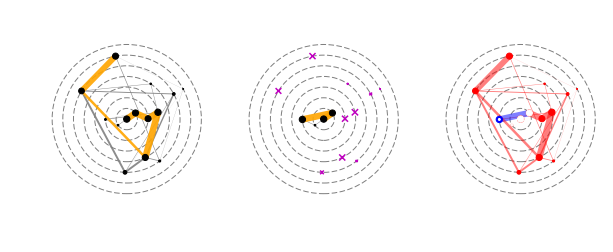

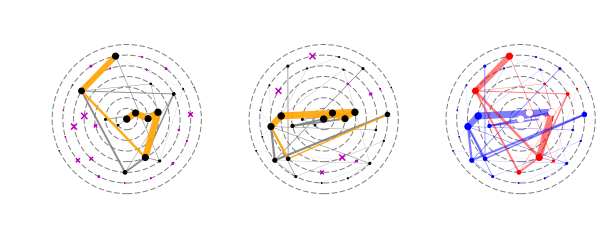

In [8]:
fig2, pos = plot_networks(G0, G2, G1, ancestor,)# pos=pos)
fig1, pos = plot_networks(G0, G1, G2, ancestor, pos=pos)

# Save output

In [193]:
f = open("example-data/network-positions.pickle", "wb")
pickle.dump(pos, f)
f.close()

fig1.savefig("figures/example-network-additive-prediction.pdf", format="pdf")
fig2.savefig("figures/example-network-pairwise-prediction.pdf", format="pdf")

In [1]:
from latticegpm.gpm import LatticeGenotypePhenotypeMap
from latticeproteins.conformations import Conformations

In [2]:
c = Conformations(12)

In [11]:
space1 = LatticeGenotypePhenotypeMap.from_mutant('WIKSKCMFCSWH', 'WWKWDCMMCKWM', Conformations=c)
space1.phenotype_type = "stabilities"
map1 = space1.map("genotypes", "phenotypes")

In [12]:
from latticeproteins.thermodynamics import LatticeThermodynamics

path = ['YCLKVDMIFHKW', 'CCLKVDMIFHKW', 'CCLKVDMIFCKW', 'CCLKVKMIFCKW', 'CHLKVKMIFCKW', 'CHLKMKMIFCKW', 'CHVKMKMIFCKW']
c = Conformations(12)
lattice = LatticeThermodynamics(1, c)
target = c.k_lowest_confs(path[0],1, 1)[0]

In [13]:
space1.wildtype

'WIKSKCMFCSWH'

In [14]:
target

'UUURRDLDDRU'

In [15]:
for p in path:
    ff = lattice.stability(p, target=target)
    print(ff)

-1.54287103024
-1.56331336034
-1.82649545952
-1.83011029602
-1.83318576312
-1.84146772031
-1.84191359562


In [16]:
12 * 19

228